In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [32]:
# read in data
df = pd.read_csv('../data/train.csv', parse_dates=['Date'])
df.loc[df['Province/State'].isnull(), 'Province/State'] = \
    df.loc[df['Province/State'].isnull(), 'Country/Region']

# get the current statusa
max_figures = df.groupby('Province/State')[['ConfirmedCases','Fatalities']].max()

In [33]:
# This data has recovered data, could be useful for better model fitting

# df_cases = pd.read_csv(
#     '../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
# )
# df_cases = pd.read_csv(
#     '../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
# )
# df_cases = pd.read_csv(
#     '../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
# )

# SEIR model - population level

In [43]:
province = 'Hubei'
N = 58.5e6

In [40]:
df_province = df[df['Province/State'] == 'Hubei'][['Date']]
df_province['I'] = df[df['Province/State'] == 'Hubei']['ConfirmedCases']
df_province['D'] = df[df['Province/State'] == 'Hubei']['Fatalities']
df_province = df_province.sort_values('Date').reset_index(drop=True)

In [103]:
# Recursive relations for SEIR model
def base_seir_model(initial_vals, params, t):
    '''
    params:
        beta:  transmission (infection) rate
        alpha: incubation rate
        gamma: recovery rate
        d:     death rate
    '''
    print 
    S_0, E_0, I_0, R_0, D_0 = initial_vals
    N = S_0 + E_0 + I_0 + R_0 + D_0
    S, E, I, R, D = [S_0], [E_0], [I_0], [R_0], [D_0]
    beta, alpha, gamma, d = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1]/N)*dt
        next_E = E[-1] + (beta*S[-1]*I[-1]/N - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*(1-d)*I[-1])*dt
        next_D = D[-1] + (gamma*d*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        D.append(next_D)
    return np.stack([S, E, I, R, D])

# Loss function for least squares fitting
def f_resid(params):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function"""
    S_model, E_model, I_model, R_model, D_model = base_seir_model(initial_vals, params, t)
    return D_actual - D_model

In [110]:
# initial guess for params
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number

beta_0 = R_0 / T_inf
alpha_0 = 1.0 / T_inc  # average incubation period
gamma_0 = 1.0 / T_inf  # average infectious period
d_0 = 0.05 # death rate
params_0 = [beta_0, alpha_0, gamma_0, d_0]

# initial values of system
I_0 = df_province.loc[0, 'I']
D_0 = df_province.loc[0, 'D']
S_0 = 100000
E_0 = I_0
R_0 = D_0
initial_vals = [S_0, E_0, I_0, R_0, D_0]

# Actuals
t = range(df_province.shape[0])
D_actual = df_province['D']
I_actual = df_province['I']

(params_fit, kvg) = optimize.leastsq(f_resid, params_0)

S_pred, E_pred, I_pred, R_pred, D_pred = base_seir_model(initial_vals, params_fit, t)

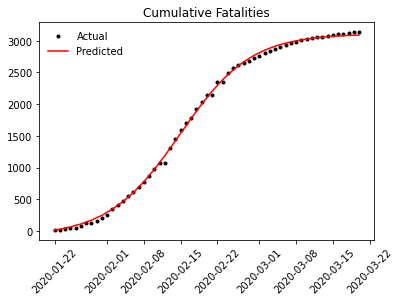

In [134]:
plt.plot(df_province['Date'].values, D_actual, '.k')
plt.plot(df_province['Date'].values, D_pred, '-r')
plt.xticks(rotation=45)
# plt.ylabel('Fatalities')
plt.legend(['Actual', 'Predicted'], frameon=False)
plt.title('Cumulative Fatalities')
plt.savefig('plots/SEIR_fatalities_{}.png'.format(province), dpi=300, bbox_inches='tight')
plt.show()

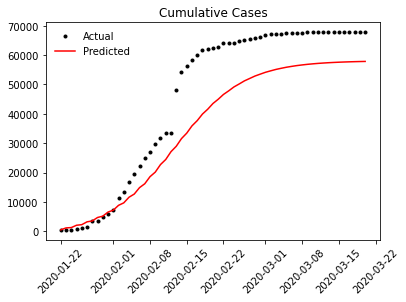

In [133]:
plt.plot(df_province['Date'].values, I_actual, '.k')
plt.plot(df_province['Date'].values, I_pred + R_pred + D_pred, '-r')
plt.xticks(rotation=45)
# plt.ylabel('Fatalities')
plt.legend(['Actual', 'Predicted'], frameon=False)
plt.title('Cumulative Cases')
plt.show()